# DS analysis

Goal: investigate what DS level means 

## Setup

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

/opt/conda/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [4]:
protein_atlas = pd.read_csv("../data/protein_atlas.csv")

In [5]:
protein_atlas.head()

,symbol,Ensembl gene id,colon,kidney,liver,pancreas,lung,prostate,brain,stomach,...,gall bladder,urinary bladder,thyroid gland,esophagus,heart,skin,ovary,bone marrow,salivary gland,Category
0,METTL25,ENSG00000127720,4.35,4.45,2.51,2.35,4.09,5.03,2.21,4.19,...,4.08,6.73,5.70,4.44,3.56,4.36,6.06,2.22,3.10,Expressed in all low
1,OR13A1,ENSG00000256574,0.02,0.04,0.02,0.00,0.02,0.19,0.00,0.09,...,0.06,0.87,0.01,0.17,0.04,0.01,0.04,0.07,0.11,Not detected
2,PPARGC1A,ENSG00000109819,8.21,25.96,25.39,2.32,5.10,3.27,5.35,4.61,...,3.93,2.81,23.18,4.50,24.55,1.34,1.29,0.01,26.07,Mixed high
3,PSMC2,ENSG00000161057,45.17,51.94,54.34,17.00,45.25,49.72,46.34,49.62,...,47.71,58.42,56.40,59.33,60.10,53.37,37.34,69.13,34.64,Expressed in all high
4,LINC02877,ENSG00000237787,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.08,Not detected


In [6]:
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')

In [7]:
brain_ds = protein_atlas.set_index('symbol')[['brain']].join(stability)
brain_ds

,brain,ds,pct
A1BG,0.83,0.423927,0.920419
A1CF,0.05,NaN,NaN
A2M,97.47,0.074283,0.332999
A2ML1,2.46,-0.027507,0.012856
A4GALT,1.79,0.050894,0.241503
...,...,...,...
NaN,0.19,NaN,NaN
NaN,0.47,NaN,NaN
NaN,0.00,NaN,NaN
NaN,0.03,NaN,NaN


In [8]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [9]:
brain_ds = brain_ds \
    .join(dm_hcp_3d_ds5.weights) \
    .dropna() \
    .set_axis(['brain','ds','pct','G1','G2','G3','G4','G5'], axis=1)
    # .loc[lambda x: np.isin(x.index, dm_hcp_3d_ds5.weights.index)] \
brain_ds

,brain,ds,pct,G1,G2,G3,G4,G5
A1BG,0.83,0.423927,0.920419,-0.015451,-0.004934,0.000699,0.016858,0.006292
AAAS,21.08,0.239969,0.762072,0.011610,0.004924,0.002749,0.021266,0.015141
AAGAB,21.95,0.134598,0.547661,-0.005098,0.019884,-0.014751,0.008616,-0.010400
AAK1,23.54,0.240441,0.762386,0.013312,0.001275,-0.002645,-0.008864,-0.024534
AARD,0.61,0.218268,0.728960,0.013120,-0.002350,-0.007395,-0.011570,-0.000021
...,...,...,...,...,...,...,...,...
ZSWIM9,2.60,0.214529,0.723567,-0.009991,0.000472,0.002506,-0.019023,0.018498
ZWINT,3.99,0.260411,0.789665,-0.012440,-0.008334,0.000574,0.004192,0.005411
ZYX,28.02,0.547722,0.965634,0.017013,0.005948,-0.003732,0.009057,-0.000944
ZZEF1,10.05,0.203827,0.705255,0.013004,-0.012945,0.009701,-0.000585,0.013878


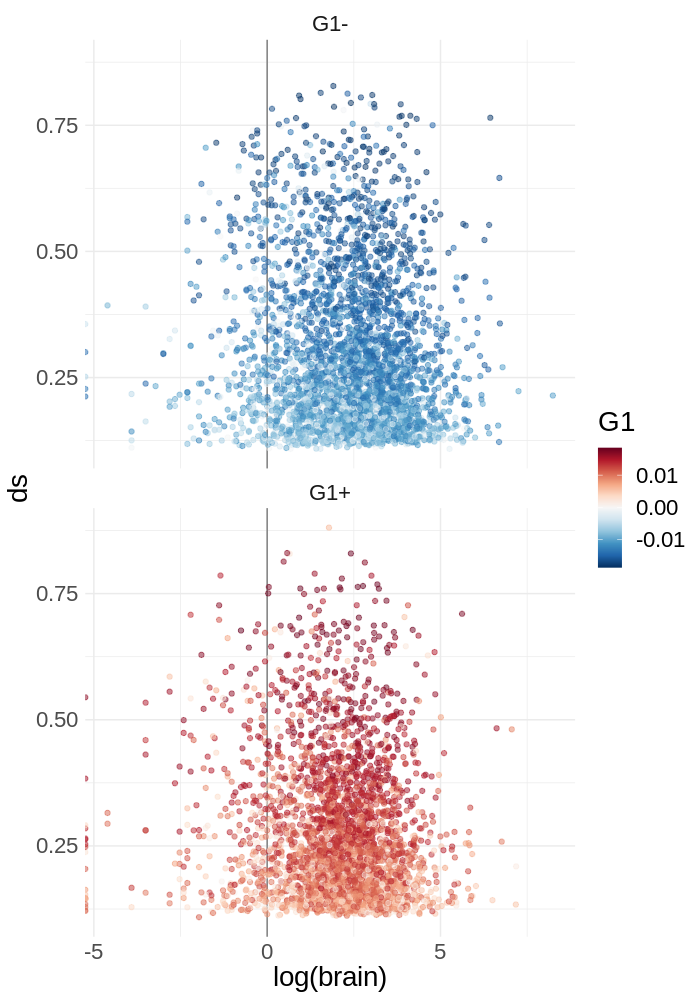

In [51]:
%%R -i brain_ds -w 7 -h 10 --units in -r 100
brain_ds %>%
mutate(G1_posneg = ifelse(G1>0,'G1+', 'G1-')) %>%
    # mutate(G1 = ifelse(G1 > quantile(G1, .9),'top10','not'),
    #        G2 = ifelse(G2 > quantile(G2, .9),'top10','not'),
    #        G3 = ifelse(G3 > quantile(G3, .9),'top10','not')
    #       ) %>%
ggplot() +
facet_wrap(~G1_posneg, ncol=1) +
geom_vline(xintercept=0, color='gray50') +
geom_point(aes(log(brain), ds, color=G1), alpha=.5) +
scale_color_gradientn(colors=rev(brewer.rdbu(100))) +
# scale_size_manual(values=c(1,2)) +
theme_minimal() + theme(text = element_text(size=20))

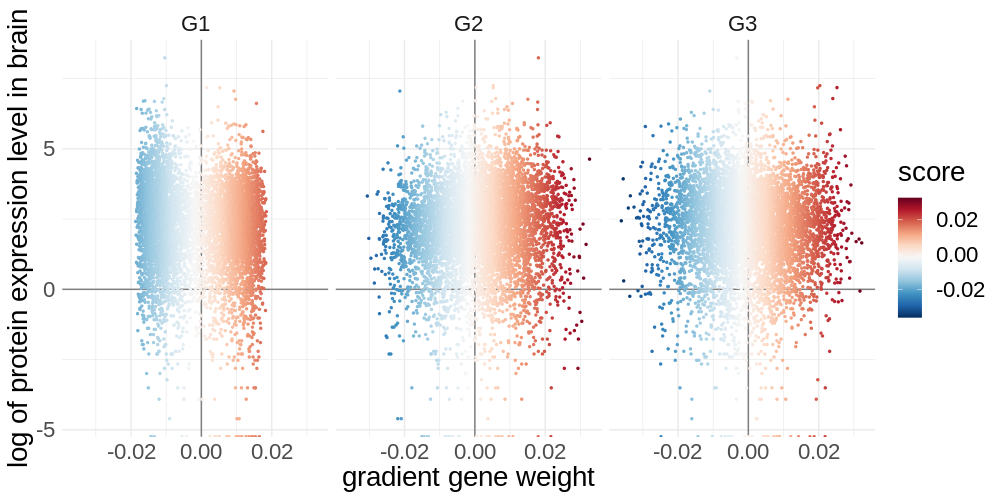

In [53]:
%%R -i brain_ds -w 10 -h 5 --units in -r 100
brain_ds %>% select(-G4, -G5) %>%
pivot_longer(G1:G3, names_to='G', values_to='score') %>%
ggplot(aes(score, log(brain))) +
facet_wrap(~G) +
geom_hline(yintercept=0, color='gray50') +
geom_vline(xintercept=0, color='gray50') +
geom_point(aes(color=score), size=.5) +
scale_color_gradientn(colors=rev(brewer.rdbu(100))) +
# stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
# geom_hex(bins = 50) +
# scale_fill_continuous(type = "viridis") +
xlab('gradient gene weight') + ylab('log of protein expression level in brain') +
theme_minimal() +
theme(text=element_text(size=20))

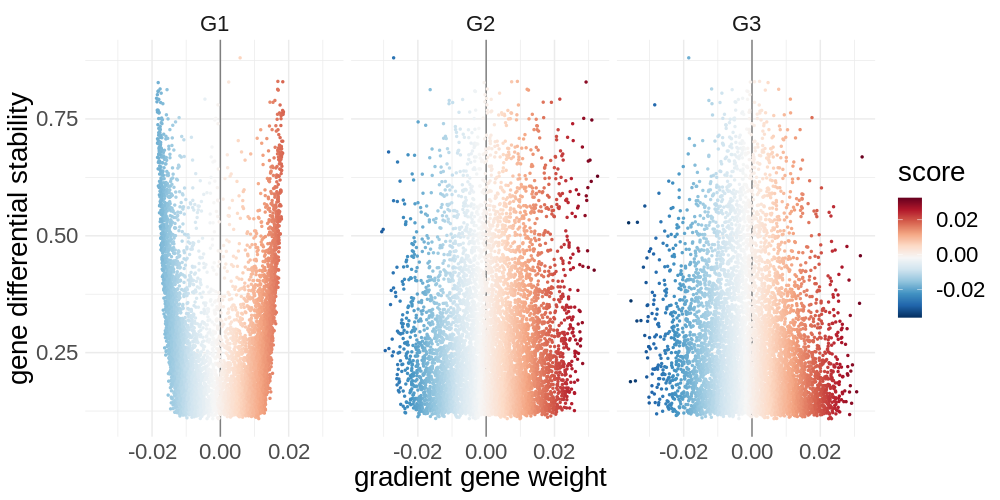

In [54]:
%%R -i brain_ds -w 10 -h 5 --units in -r 100
brain_ds %>% select(-G4, -G5) %>%
pivot_longer(G1:G3, names_to='G', values_to='score') %>%
ggplot(aes(score, ds)) +
facet_wrap(~G) +
# geom_hline(yintercept=0, color='gray50') +
geom_vline(xintercept=0, color='gray50') +
geom_point(aes(color=score), size=.5) +
scale_color_gradientn(colors=rev(brewer.rdbu(100))) +
# stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
# geom_hex(bins = 50) +
# scale_fill_continuous(type = "viridis") +
xlab('gradient gene weight') + ylab('gene differential stability') +
theme_minimal() +
theme(text=element_text(size=20))

### Match gene symbols for protein atlas and save

In [37]:
import mygene
mg = mygene.MyGeneInfo()
gene_matches = mg.querymany(protein_atlas['Ensembl gene id'], scopes='ensembl.gene')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20050...done.
Finished.
723 input query terms found no hit:
	['ENSG00000267596', 'ENSG00000204533', 'ENSG00000132139', 'ENSG00000215897', 'ENSG00000188279', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [41]:
gene_matches = pd.DataFrame(gene_matches).set_index('query')['symbol']

In [48]:
protein_atlas.join(gene_matches, on='Ensembl gene id').set_index('symbol').to_csv('../data/protein_atlas.csv')

In [36]:
stability

,ds,pct
gene_symbol,,
MET,0.880732,1.000000
SV2C,0.830289,0.999937
RHBDL3,0.829522,0.999875
CTXN3,0.828956,0.999812
SLA,0.827744,0.999749
...,...,...
DEFB123,-0.058273,0.000314
MCAT,-0.058465,0.000251
ARMC6,-0.060564,0.000188


In [18]:
np.median(protein_atlas.drop(['Ensembl gene id', 'Category'],axis=1).values)

5.06

In [22]:
brain_genes = protein_atlas.set_index('Ensembl gene id')['brain'].loc[lambda x: x>5.06*4]

In [ ]:
import mygene
mg = mygene.MyGeneInfo()
gene_matches = mg.querymany(brain_genes.index, scopes='ensembl.gene')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4359...done.
Finished.
37 input query terms found no hit:
	['ENSG00000005955', 'ENSG00000017373', 'ENSG00000187145', 'ENSG00000250588', 'ENSG00000077809', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [30]:
matches = pd.DataFrame(gene_matches).loc[:,['query', 'symbol']]

In [33]:
brain_genes.to_frame().join(matches.set_index('query')).

,brain,symbol
Ensembl gene id,,
ENSG00000161057,46.34,PSMC2
ENSG00000189241,108.92,TSPYL1
ENSG00000172020,176.08,GAP43
ENSG00000132604,25.34,TERF2
ENSG00000139218,23.07,SCAF11
...,...,...
ENSG00000171634,22.83,BPTF
ENSG00000158560,61.95,DYNC1I1
ENSG00000138279,60.88,ANXA7


In [34]:
pd.read_csv('../data/jakob_brain_genes.csv')

,gene
0,TSPAN6
1,DPM1
2,SCYL3
3,C1orf112
4,GCLC
...,...
7966,HIST1H4A
7967,HIST1H2AM
7968,HIST1H4B
7969,HIST1H3H
